In [1]:
import numpy as np
import matplotlib.pyplot as plt
from xsigmamodules.Util import (
    blackScholes,
    sigmaVolatilityInspired,
    implied_volatility_enum,
)
from xsigmamodules.util.numpy_support import xsigmaToNumpy, numpyToXsigma
from common.volatilityDensityModel import (
    create_interactive_model,
    plot_density,
    generate_sample_data,
    plot_volatility_smile,
)

from xsigmamodules.Market import volatilityModelExtendedSvi

from xsigmamodules.Math import (
    solverOptionsCeres,
    solverOptionsLm,
    solverOptionsNlopt,
    nlopt_algo_name,
)

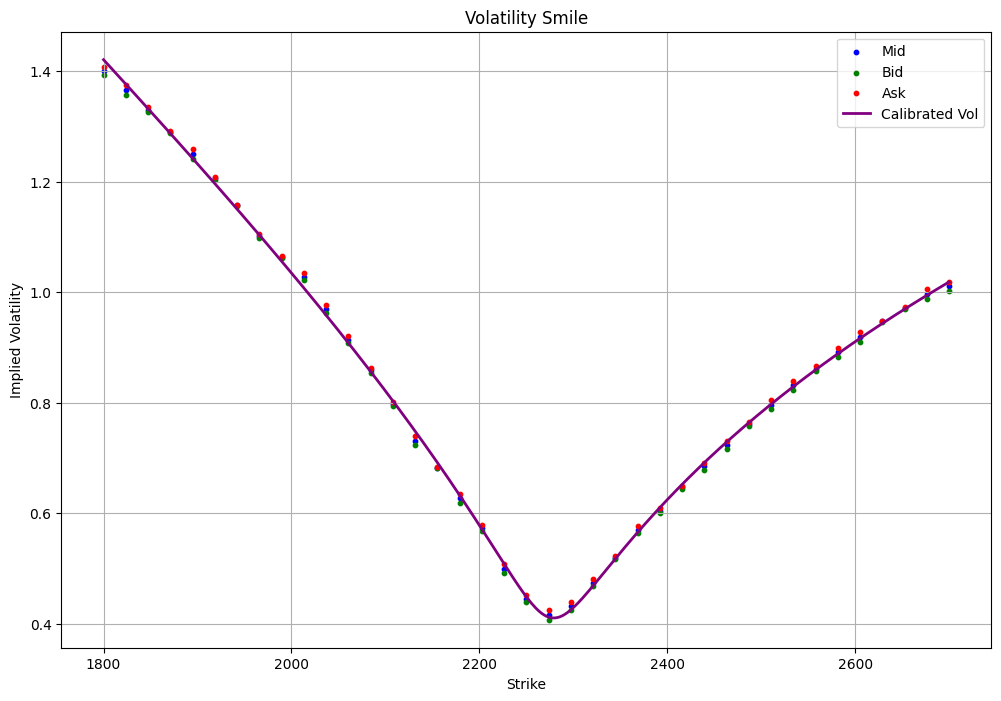

In [2]:
# Set up parameters
n = 400
expiry = 1
spot = 2273.684211
r = 0.003
q = 0.0022
beta = 0.4158
rho = 0.2256
volvol = 0.2

# Generate sample data
calibration_strikes, bid_values, ask_values, mid_values = generate_sample_data()

# Create and calibrate the volatilityModelExtendedSvi object
initial_guess_obj = volatilityModelExtendedSvi(
    spot, 0.2, volvol, beta, rho, r, q, 0.00006
)

options = solverOptionsCeres(500, 1e-14, 1e-14, 1e-14)
calibrated_obj_ceres = volatilityModelExtendedSvi.calibrate(
    numpyToXsigma(calibration_strikes),
    numpyToXsigma(mid_values),
    spot,
    expiry,
    options,
    1,
    1,
    initial_guess_obj,
)

options = solverOptionsNlopt(
    nlopt_algo_name.AUGMENTED_LAGRANGIAN_WITH_BOBYQA, 500, 1e-14, 1e-14, 1e-14
)
calibrated_obj_nlopt = volatilityModelExtendedSvi.calibrate(
    numpyToXsigma(calibration_strikes),
    numpyToXsigma(mid_values),
    spot,
    expiry,
    options,
    1,
    1,
    initial_guess_obj,
)

options = solverOptionsLm(500, 1e-14, 1e-14, 1e-14)
calibrated_obj_lm = volatilityModelExtendedSvi.calibrate(
    numpyToXsigma(calibration_strikes),
    numpyToXsigma(mid_values),
    spot,
    expiry,
    options,
    1,
    1,
    initial_guess_obj,
)

# Calculate volatilities
vols = np.zeros(n)
strikes = np.linspace(1800, 2700, n)
calibrated_obj_ceres.implied_volatility(
    numpyToXsigma(vols),
    numpyToXsigma(strikes),
    1.0,
    expiry,
    implied_volatility_enum.LOG_NORMAL,
)

# Plot the results
plot_volatility_smile(
    calibration_strikes, strikes, bid_values, ask_values, mid_values, vols
)

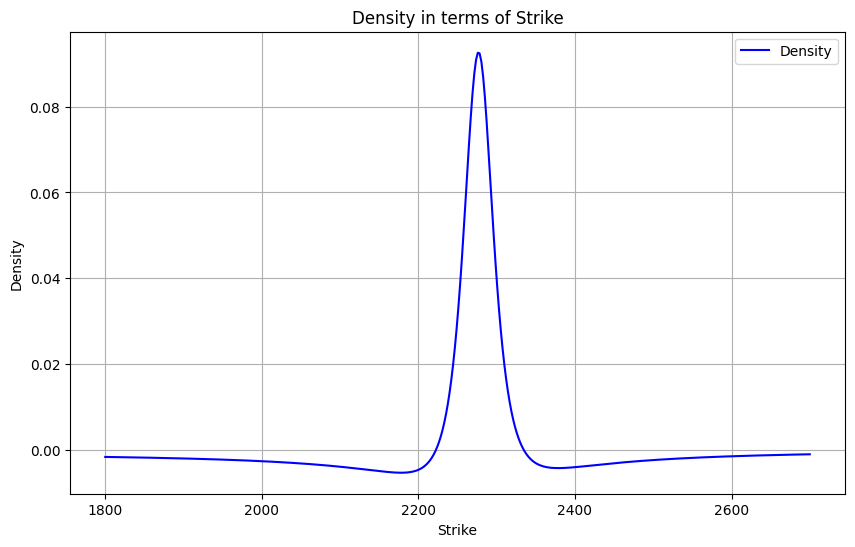

In [3]:
plot_density(calibrated_obj_ceres, strikes, spot, expiry)

$$
k = \frac{\tanh \left( \text{Ctrl} \cdot \log \left( \frac{K}{F} \right) \right)}{\text{Ctrl} \cdot \sqrt{T}}
$$

$ \text{Case:} \ \text{smile} \geq 0 \ \text{and} \ 1_{K < F} \cdot \text{Put} + 1_{K \geq F} \cdot \text{Call} \geq 0 $

$$
\sigma^2(k) = \sigma_0^2 + 2 \cdot \text{skew} \cdot k + \frac{\text{smile}}{\sigma^2(k)} \cdot k^2 + \frac{1_{K < F} \cdot \text{Put} + 1_{K \geq F} \cdot \text{Call}}{\sigma^4(k)} \cdot k^4
$$

$ \text{Case:} \ \text{smile} \geq 0 \ \text{and} \ 1_{K < F} \cdot \text{Put} + 1_{K \geq F} \cdot \text{Call} \leq 0 $

$$
\sigma^2(k) = \sigma_0^2 + 2 \cdot \text{skew} \cdot k + \frac{\text{smile}}{\sigma^2(k)} \cdot k^2 + \frac{1_{K < F} \cdot \text{Put} + 1_{K \geq F} \cdot \text{Call}}{\tilde{\sigma}^6(k)} \cdot \sigma^2(k) \cdot k^4
$$

$$
\tilde{\sigma}^2(k) = \sigma_0^2 + 2 \cdot \text{skew} \cdot k + \frac{\text{smile}}{\tilde{\sigma}^2(k)} \cdot k^2
$$

$ \text{Case:} \ \text{smile} < 0 \ \text{and} \ 1_{K < F} \cdot \text{Put} + 1_{K \geq F} \cdot \text{Call} \geq 0 $

$$
\sigma^2(k) = \sigma_0^2 + 2 \cdot \text{skew} \cdot k + \frac{\text{smile}}{\tilde{\sigma}^4(k)} \sigma^2(k) \cdot k^2 + \frac{1_{K < F} \cdot \text{Put} + 1_{K \geq F} \cdot \text{Call}}{\sigma^4(k)} \cdot k^4
$$

$$
\tilde{\sigma}^2(k) = \sigma_0^2 + 2 \cdot \text{skew} \cdot k  + \frac{ 1_{K < F} \text{Put} + 1_{K \geq F} \text{Call}}{\tilde{\sigma}^4(k)} \cdot k^4
$$

$ \text{Case:} \ \text{smile} < 0 \ \text{and} \ 1_{K < F} \cdot \text{Put} + 1_{K \geq F} \cdot \text{Call} \leq 0 $

$$
\sigma^2(k) = \sigma_0^2 + 2 \cdot \text{skew} \cdot k + \frac{\text{smile}}{\tilde{\sigma}^4(k)} \sigma^2(k) \cdot k^2 + \frac{1_{K < F} \cdot \text{Put} + 1_{K \geq F} \cdot \text{Call}}{\tilde{\sigma}^6(k)} \sigma^2(k) \cdot k^4
$$

$$
\tilde{\sigma}^2(k) = \max(\sigma_0^2 + 2 \cdot \text{skew} \cdot k, 0.0001)
$$

In [ ]:
initial_values = {
    "fwd": 1.0,
    "time": 0.333,
    "ctrl_p": 0.2,
    "ctrl_c": 0.2,
    "atm": 0.1929,
    "skew": 0.02268,
    "smile": 0.00317,
    "put": 0.00213,
    "call": 0.00006,
}

# Create and display the interactive model
interactive_model = create_interactive_model(initial_values, "asv")
display(interactive_model)

In [ ]:
initial_values = {
    "fwd": 1,  # Midpoint of strike range
    "time": 0.333,
    "b": 0.1,
    "m": 0.01,
    "sigma": 0.4,
}

# Create and display the interactive model
interactive_model = create_interactive_model(initial_values, "svi")
display(interactive_model)

In [6]:
obj_svi = sigmaVolatilityInspired(
    spot, initial_values["b"], initial_values["m"], initial_values["sigma"]
)
obj_svi.calibrate(numpyToXsigma(mid_values), numpyToXsigma(calibration_strikes))

<xsigmamodules.Util.sigmaVolatilityInspired(0x00000206A6BB44F0) at 0x00000206A6BB44F0>

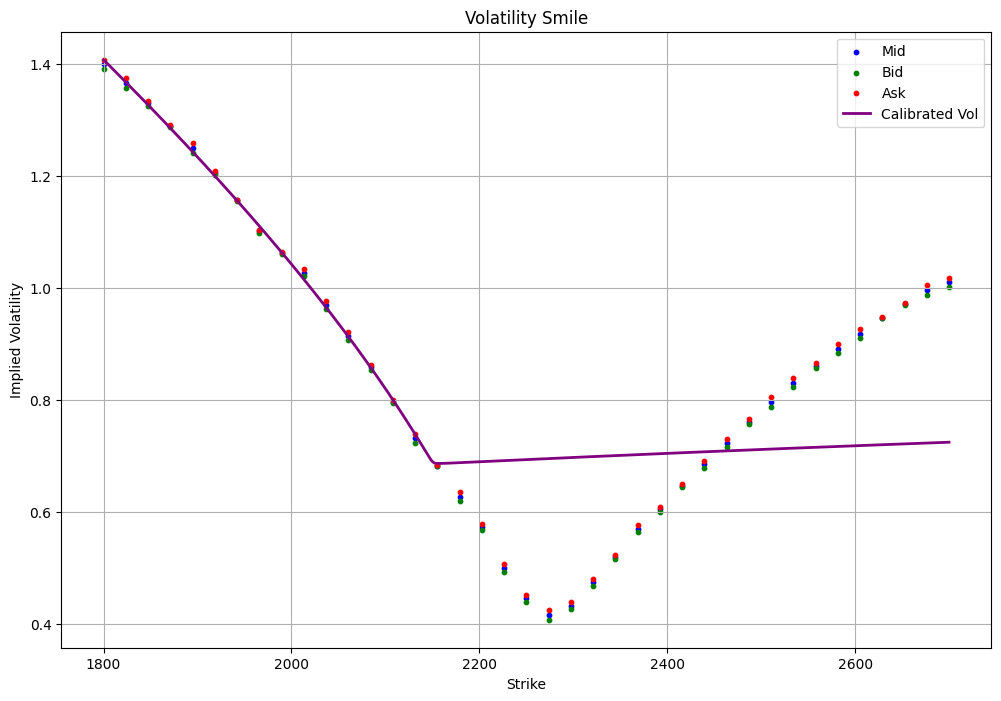

: 

In [ ]:
vols = np.zeros(n)
strikes = np.linspace(1800, 2700, n)
obj_svi.svi(numpyToXsigma(vols), numpyToXsigma(strikes))

# Plot the results
plot_volatility_smile(
    calibration_strikes, strikes, bid_values, ask_values, mid_values, vols
)